# 1 Querying Big Query IMDB Database

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [3]:
pip install --upgrade google-cloud-bigquery

In [4]:
import os

# Set the path to your service account JSON key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "artful-patrol-397019-f10bd20fd595.json"


In [5]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

query = """
    SELECT *
    FROM (
        SELECT *,
            PARSE_DATE('%Y', CAST(start_year AS STRING)) AS year,
            SPLIT(genres, ',')[SAFE_OFFSET(0)] AS genre1,
            SPLIT(genres, ',')[SAFE_OFFSET(1)] AS genre2,
            SPLIT(genres, ',')[SAFE_OFFSET(2)] AS genre3
        FROM `bigquery-public-data.imdb.reviews`
        INNER JOIN `bigquery-public-data.imdb.title_basics`
        ON `bigquery-public-data.imdb.reviews`.movie_id = `bigquery-public-data.imdb.title_basics`.tconst
        WHERE title_type = 'movie'
    )
"""

# Set use_legacy_sql to False to use standard SQL syntax.
job_config = bigquery.QueryJobConfig(use_legacy_sql=False)

# Start the query, passing in the extra configuration.
query_job = client.query(query, job_config=job_config)  # Make an API request.

# print("The query data:")
# for row in query_job:
#     print(row)


In [6]:
df = query_job.to_dataframe()
df.to_csv("imdb_movie_reviews.csv")
df.head()

review split     label  \
0  Cult purchasers are unquestionably familiar wi...  test  Negative   
1  Acclaimed Argentine horror director Emilio Vie...  test  Negative   
2  Dr. Krellman wants to save his son Julio who's...  test  Negative   
3  This film was a Mexican made horror film from ...  test  Negative   
4  The following "review" is one from the wrong s...  test  Negative   

    movie_id  reviewer_rating                             movie_url title  \
0  tt0063090                3  http://www.imdb.com/title/tt0063090/  None   
1  tt0063090                2  http://www.imdb.com/title/tt0063090/  None   
2  tt0063090                4  http://www.imdb.com/title/tt0063090/  None   
3  tt0063090                3  http://www.imdb.com/title/tt0063090/  None   
4  tt0063090                2  http://www.imdb.com/title/tt0063090/  None   

      tconst title_type             primary_title  \
0  tt0063090      movie  Night of the Bloody Apes   
1  tt0063090      movie  Night of the Bloody Apes   
2  tt0063090      movie  Night of the Bloody Apes   
3  tt0063090      movie  Night of the Bloody Apes   
4  tt0063090      movie  Night of the Bloody Apes   

                  original_title  is_adult  start_year  end_year  \
0  La horripilante bestia humana         0        1969      <NA>   
1  La horripilante bestia humana         0        1969      <NA>   
2  La horripilante bestia humana         0        1969      <NA>   
3  La horripilante bestia humana         0        1969      <NA>   
4  La horripilante bestia humana         0        1969      <NA>   

   runtime_minutes              genres        year genre1 genre2  genre3  
0               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
1               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
2               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
3               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
4               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror

# 2 Data Preparation for NLP

Check reviews for empty values.

In [7]:
df = df[~df["review"].str.isspace()] # check review has no spaces
df[df["review"].apply(lambda review: review == "")] # check for empty review values as this would hinder performance
df = df[df["review"].str.strip().astype('bool')]

In [8]:
df.head()

review split     label  \
0  Cult purchasers are unquestionably familiar wi...  test  Negative   
1  Acclaimed Argentine horror director Emilio Vie...  test  Negative   
2  Dr. Krellman wants to save his son Julio who's...  test  Negative   
3  This film was a Mexican made horror film from ...  test  Negative   
4  The following "review" is one from the wrong s...  test  Negative   

    movie_id  reviewer_rating                             movie_url title  \
0  tt0063090                3  http://www.imdb.com/title/tt0063090/  None   
1  tt0063090                2  http://www.imdb.com/title/tt0063090/  None   
2  tt0063090                4  http://www.imdb.com/title/tt0063090/  None   
3  tt0063090                3  http://www.imdb.com/title/tt0063090/  None   
4  tt0063090                2  http://www.imdb.com/title/tt0063090/  None   

      tconst title_type             primary_title  \
0  tt0063090      movie  Night of the Bloody Apes   
1  tt0063090      movie  Night of the Bloody Apes   
2  tt0063090      movie  Night of the Bloody Apes   
3  tt0063090      movie  Night of the Bloody Apes   
4  tt0063090      movie  Night of the Bloody Apes   

                  original_title  is_adult  start_year  end_year  \
0  La horripilante bestia humana         0        1969      <NA>   
1  La horripilante bestia humana         0        1969      <NA>   
2  La horripilante bestia humana         0        1969      <NA>   
3  La horripilante bestia humana         0        1969      <NA>   
4  La horripilante bestia humana         0        1969      <NA>   

   runtime_minutes              genres        year genre1 genre2  genre3  
0               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
1               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
2               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
3               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror  
4               83  Crime,Drama,Horror  1969-01-01  Crime  Drama  Horror

Extract reviews and label from the dataframe

In [9]:
df[df["label"] != "Unsupervised"][["review", "label", "reviewer_rating"]]

review     label  \
0      Cult purchasers are unquestionably familiar wi...  Negative   
1      Acclaimed Argentine horror director Emilio Vie...  Negative   
2      Dr. Krellman wants to save his son Julio who's...  Negative   
3      This film was a Mexican made horror film from ...  Negative   
4      The following "review" is one from the wrong s...  Negative   
...                                                  ...       ...   
36847  I own a Video store with hundreds of documenta...  Positive   
36848  The End of Suburbia neatly collects many of th...  Positive   
36849  I have the good common logical sense to know t...  Positive   
36850  I always knew the day was coming. We all knew....  Positive   
36851  This documentary was my first introduction to ...  Positive   

       reviewer_rating  
0                    3  
1                    2  
2                    4  
3                    3  
4                    2  
...                ...  
36847               10  
36848                8  
36849               10  
36850               10  
36851                9  

[36852 rows x 3 columns]

In [10]:
review_df = df[df["label"] != "Unsupervised"][["review", "label", "reviewer_rating"]]

In [11]:
!pip install plotly

In [12]:
import plotly.express as px

Let's look at the split of labels positive, negative and unsupervised.

The positive and negative are the same length the data is balanced

In [13]:
fig = px.histogram(df, x='label', template='plotly_white', title='Reviews by label')
fig.update_xaxes(categoryorder='category ascending').update_yaxes(title='Number of reivews')
fig.show()

In [14]:
fig = px.histogram(review_df, x='label', template='plotly_white', title='Reviews by label')
fig.update_xaxes(categoryorder='category ascending').update_yaxes(title='Number of reivews')
fig.show()

# 2.1 Tokenisation Use NLTK to prepare the reviews

In [15]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.probability import FreqDist
stop_words = set(stopwords.words("english")) # set stop words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Create bag of words
review_df["words"] = review_df["review"].apply(lambda x: nltk.word_tokenize(x))

In [17]:
# Creating a function to remove punctuation
import string

def remove_punc(word:list):

  return ''.join([char for char in word if char not in string.punctuation])


# Apply the function to each list of words in the "words" column
review_df["words_clean"] = review_df["words"].apply(lambda word_list: [remove_punc(word) for word in word_list])

In [18]:
# Create bag of sentences
review_df["sentences"] = review_df["review"].apply(lambda x: nltk.sent_tokenize(x))

In [19]:
review_df["sentences"]

0        [Cult purchasers are unquestionably familiar w...
1        [Acclaimed Argentine horror director Emilio Vi...
2        [Dr. Krellman wants to save his son Julio who'...
3        [This film was a Mexican made horror film from...
4        [The following "review" is one from the wrong ...
                               ...                        
36847    [I own a Video store with hundreds of document...
36848    [The End of Suburbia neatly collects many of t...
36849    [I have the good common logical sense to know ...
36850    [I always knew the day was coming., We all kne...
36851    [This documentary was my first introduction to...
Name: sentences, Length: 36852, dtype: object

In [20]:
review_df["words"]

0        [Cult, purchasers, are, unquestionably, famili...
1        [Acclaimed, Argentine, horror, director, Emili...
2        [Dr., Krellman, wants, to, save, his, son, Jul...
3        [This, film, was, a, Mexican, made, horror, fi...
4        [The, following, ``, review, '', is, one, from...
                               ...                        
36847    [I, own, a, Video, store, with, hundreds, of, ...
36848    [The, End, of, Suburbia, neatly, collects, man...
36849    [I, have, the, good, common, logical, sense, t...
36850    [I, always, knew, the, day, was, coming, ., We...
36851    [This, documentary, was, my, first, introducti...
Name: words, Length: 36852, dtype: object

In [21]:
# looping through each to remove stop words
review_df["no_stop_words"] = review_df["words_clean"].apply(lambda words_list: [word for word in words_list if word.lower() not in stop_words])

In [22]:
review_df["no_stop_words"]

0        [Cult, purchasers, unquestionably, familiar, t...
1        [Acclaimed, Argentine, horror, director, Emili...
2        [Dr, Krellman, wants, save, son, Julio, dying,...
3        [film, Mexican, made, horror, film, late, 60s,...
4        [following, , review, , one, wrong, side, trac...
                               ...                        
36847    [Video, store, hundreds, documentaries, , seen...
36848    [End, Suburbia, neatly, collects, many, concer...
36849    [good, common, logical, sense, know, oil, last...
36850    [always, knew, day, coming, , knew, , much, oi...
36851    [documentary, first, introduction, Peak, Oil, ...
Name: no_stop_words, Length: 36852, dtype: object

In [23]:
review_df["frequency"] = review_df["no_stop_words"].apply(lambda word_list: FreqDist(word_list))

I am going to create a function to take a column which contains lists of words for each row and combine these into one whole list of words as this is something we will be repeating for different stages of NLP process.

In [24]:
def combine_words(df_col: pd.core.frame.DataFrame):
  """
    Combine words from a DataFrame of word lists into a single list.

    Args:
        word_list (pd.core.frame.DataFrame): A DataFrame containing lists of words.

    Returns:
        list: A list containing all the words from the input DataFrame, with duplicates removed.

    Example:
        >>> word_df = pd.DataFrame({'words': [['apple', 'banana'], ['cherry', 'date']]})
        >>> combine_words(word_df)
        ['apple', 'banana', 'cherry', 'date']
  """

  return [word for word_list in df_col for word in word_list if word != ""]

Combine all the non stop words into one list and see the most common words used in these reviews, that are not standard stop words.

In [25]:
all_words = combine_words(review_df["no_stop_words"]) # select words - not empty spaces and compile into one list
fdist = FreqDist(all_words)
# fdist.most_common(20)

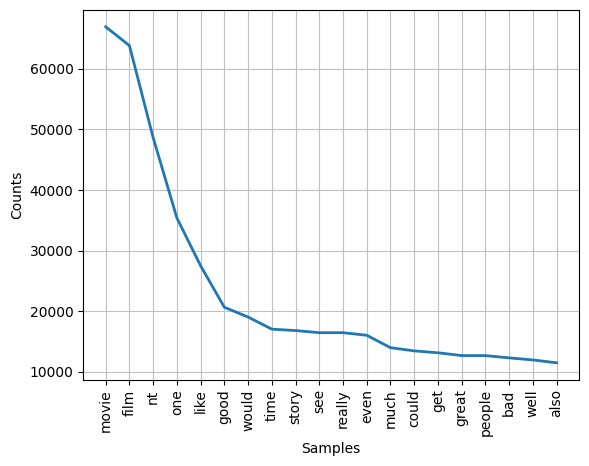

<Axes: xlabel='Samples', ylabel='Counts'>

In [26]:
fdist.plot(20)

We see some very expeced common words such as movie, film given these are all movie reviews, these are much higher than the noting of any other word at 100k plus. We also note the commonality of sentiment driven words such as "great", "bad", "good" and also some context words such as refering to the story, time etc.

# 2.2 Creating a word cloud with the tokenised values

Let us create a function to join the complete list of words if required and then create a word cloud from this as we will try this for different outputs of our NLP

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(all_words: list):
    """
    Create and display a word cloud from a list of words.

    Args:
        all_words (list): A list of words to create the word cloud from.

    Returns:
        tuple: A tuple containing the joined words as a string and the WordCloud object.

    Example:
        >>> words = ["apple", "banana", "cherry", "date", "apple", "banana"]
        >>> joined_words, word_cloud = create_wordcloud(words)
    """
    # Join all words into a string of words
    joined_words = " ".join(all_words)

    # Initialize the word cloud
    word_cloud = WordCloud(max_words=50, background_color="white", stopwords=["film", "movie"]).generate(joined_words) # exclude those words

    # Create the plot
    plt.figure(figsize=(15, 10))
    plt.imshow(word_cloud)

    # Axis
    plt.axis("off")
    plt.show()

    return joined_words, word_cloud

These are the most common non stop words across the data set.

I have excluded film and movie as these are just common words to this type of data

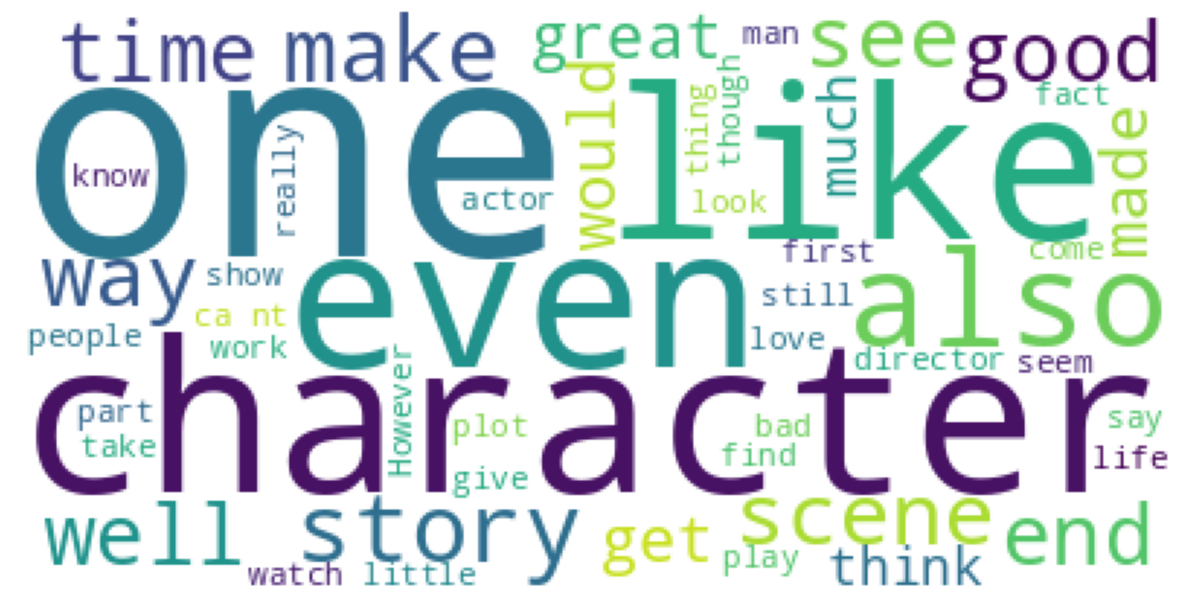

In [28]:
from wordcloud import WordCloud

# use create_word cloud function
joined_words, word_cloud = create_wordcloud(all_words)


# 2.3 Stemming words from reviews

Stemming Algorithm: Choose a stemming algorithm. Common algorithms include the Porter stemming algorithm and the Snowball stemming algorithm. These algorithms apply a series of rules to reduce words to their root form. For instance, "loved" might be stemmed to "love."

Stemming: Apply the chosen stemming algorithm to each token in the tokenized text. The algorithm will attempt to remove prefixes or suffixes to bring the word to its base form. For example:
"running" -> "run"
"jumps" -> "jump"
"better" -> "better" (in some cases, words may not change)



Benefits:
Reduction in Dimensionality: Stemming reduces the number of unique words in the dataset, which can be especially helpful in text analysis where the vocabulary can be vast.
Improved Text Matching: Stemmed words can enhance text matching and retrieval. For example, when searching for reviews about "running," you'd want to find documents containing "run" as well.

Challenges:
Over-stemming: Stemming may sometimes remove too many characters from a word, leading to loss of meaning. For instance, "unhappy" might become "unhappi," which is not a recognized word.
Under-stemming: On the other hand, stemming may not always reduce words to their most basic form. For example, "happily" might remain as "happily" instead of "happy."

In movie review analysis, stemming can help reduce the complexity of the text data and make it easier to identify trends, sentiments, and patterns in the reviews. However, it's crucial to consider its limitations and the specific requirements of your analysis before applying stemming.

We will use Porters stemmer as this tends to be the fastest and we are only looking at English reviews. It also tends to have the lowest error rate.

In [29]:
# stemming imports
from nltk.stem import PorterStemmer

# intilise
stemmer = PorterStemmer()

# Apply to our dataframe of movie review - no stop words
review_df["stemmed_words"] = review_df["no_stop_words"].apply(lambda word_list: [stemmer.stem(word) for word in word_list])

review_df.head()

review     label  \
0  Cult purchasers are unquestionably familiar wi...  Negative   
1  Acclaimed Argentine horror director Emilio Vie...  Negative   
2  Dr. Krellman wants to save his son Julio who's...  Negative   
3  This film was a Mexican made horror film from ...  Negative   
4  The following "review" is one from the wrong s...  Negative   

   reviewer_rating                                              words  \
0                3  [Cult, purchasers, are, unquestionably, famili...   
1                2  [Acclaimed, Argentine, horror, director, Emili...   
2                4  [Dr., Krellman, wants, to, save, his, son, Jul...   
3                3  [This, film, was, a, Mexican, made, horror, fi...   
4                2  [The, following, ``, review, '', is, one, from...   

                                         words_clean  \
0  [Cult, purchasers, are, unquestionably, famili...   
1  [Acclaimed, Argentine, horror, director, Emili...   
2  [Dr, Krellman, wants, to, save, his, son, Juli...   
3  [This, film, was, a, Mexican, made, horror, fi...   
4  [The, following, , review, , is, one, from, th...   

                                           sentences  \
0  [Cult purchasers are unquestionably familiar w...   
1  [Acclaimed Argentine horror director Emilio Vi...   
2  [Dr. Krellman wants to save his son Julio who'...   
3  [This film was a Mexican made horror film from...   
4  [The following "review" is one from the wrong ...   

                                       no_stop_words  \
0  [Cult, purchasers, unquestionably, familiar, t...   
1  [Acclaimed, Argentine, horror, director, Emili...   
2  [Dr, Krellman, wants, save, son, Julio, dying,...   
3  [film, Mexican, made, horror, film, late, 60s,...   
4  [following, , review, , one, wrong, side, trac...   

                                           frequency  \
0  {'Cult': 1, 'purchasers': 1, 'unquestionably':...   
1  {'Acclaimed': 1, 'Argentine': 1, 'horror': 1, ...   
2  {'Dr': 1, 'Krellman': 1, 'wants': 1, 'save': 1...   
3  {'film': 5, 'Mexican': 2, 'made': 2, 'horror':...   
4  {'following': 1, '': 164, 'review': 3, 'one': ...   

                                       stemmed_words  
0  [cult, purchas, unquestion, familiar, term, , ...  
1  [acclaim, argentin, horror, director, emilio, ...  
2  [dr, krellman, want, save, son, julio, die, he...  
3  [film, mexican, made, horror, film, late, 60, ...  
4  [follow, , review, , one, wrong, side, track, ...

Now let us visualise the most common stemmed words in thse reviews - we will use the functions we created earlier

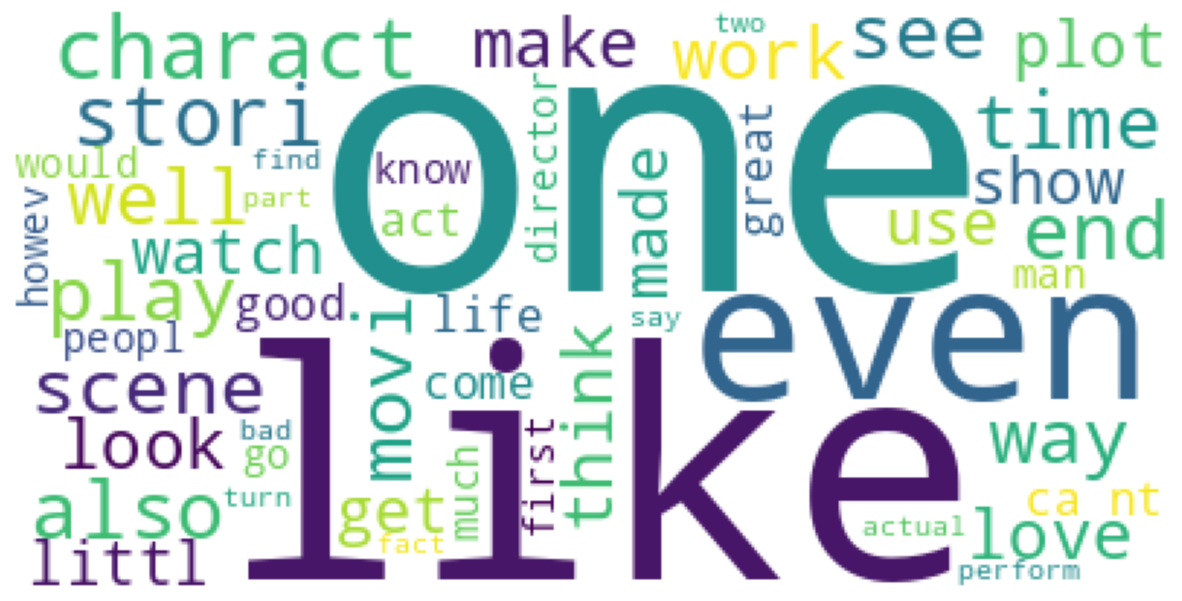

In [30]:
all_words = combine_words(review_df["stemmed_words"])
joined_words, word_cloud = create_wordcloud(all_words)

# 2.4 Lemmatizing of reviews

 Lemmatization is used to standardize words in movie reviews. It reduces words to their base form, making it easier to analyze text and derive meaningful insights.

 Reducing Variations: Movie reviews often contain various grammatical forms of words (e.g., "running," "ran," "runs" for the lemma "run"). Lemmatization reduces these variations to a common lemma, simplifying the analysis.

 Part of Speech Consideration: Lemmatization often considers the part of speech (e.g., verb, noun, adjective) of a word to determine its lemma. This context-aware approach helps maintain the meaning of the word.

 Comparison with Stemming: Lemmatization differs from stemming, which also reduces words to their base form. However, stemming is a more aggressive process that chops off prefixes and suffixes, potentially resulting in non-real words. Lemmatization, on the other hand, provides valid words as lemmas.

In [31]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# intilise
lemmatizer = WordNetLemmatizer()

# Apply to our dataframe of movie review - no stop words
review_df["lemm_words"] = review_df["no_stop_words"].apply(lambda word_list: [lemmatizer.lemmatize(word) for word in word_list])

# review_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


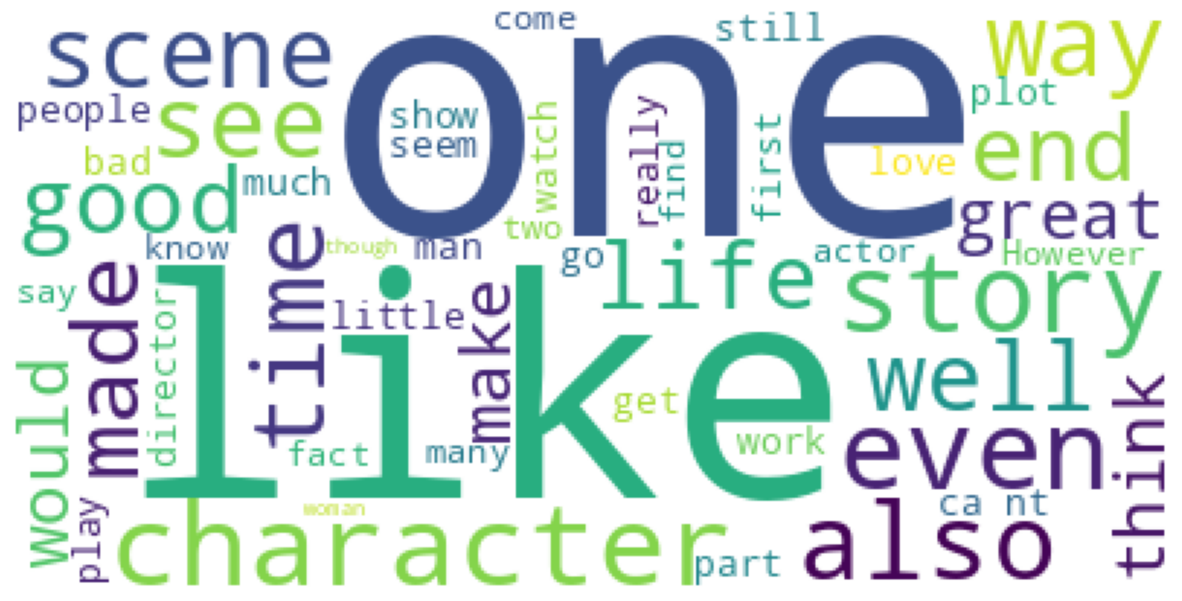

In [32]:
all_words = combine_words(review_df["lemm_words"])
joined_words, word_cloud = create_wordcloud(all_words)

# 2.5 Visualise NLP functions by Label

Below are the most common Lemmatize words for reviews that have been labelled positive.

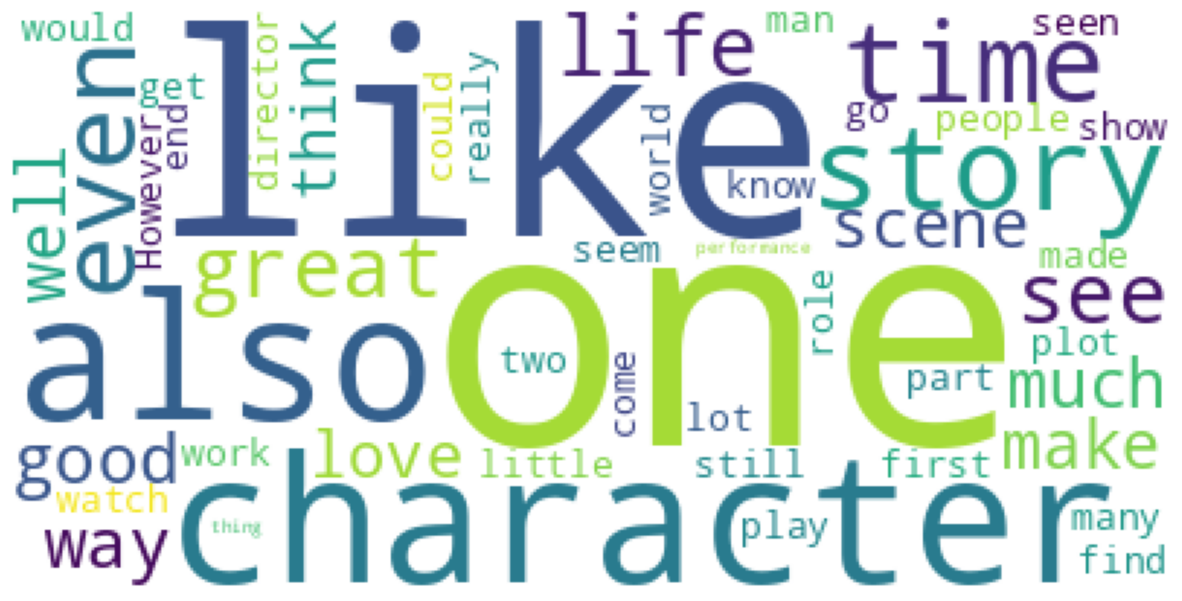

In [33]:
all_words = combine_words(review_df[review_df["label"]=="Positive"]["lemm_words"])
joined_words, word_cloud = create_wordcloud(all_words)
# plt.title("Words for Positive reviews")

As expected for positive reviews we are seeing the most common words being those who tend to have a positive connotationtion - words such as "good", "like", "great", also the word "one" is significant which could have some relevance for when we get to modelling.

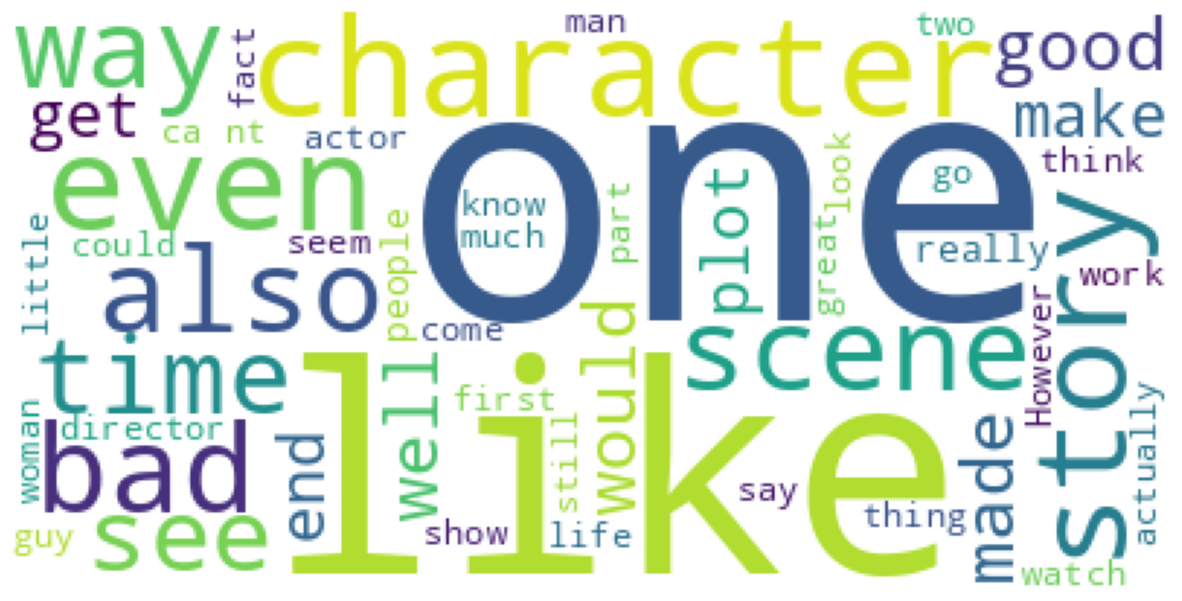

In [34]:
all_words = combine_words(review_df[review_df["label"]=="Negative"]["lemm_words"])
joined_words, word_cloud = create_wordcloud(all_words)

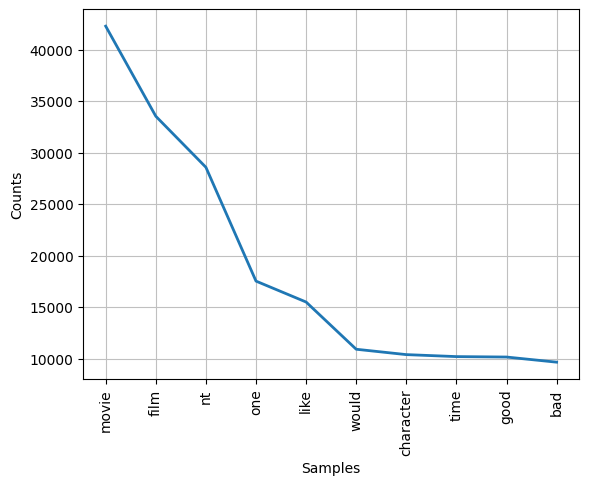

<Axes: xlabel='Samples', ylabel='Counts'>

In [35]:
fdist = FreqDist(all_words)
fdist.plot(10)

Here we see negative words such as "bad", but it is mixed in with words like "like" which could be used as a comparative rather than "I Like" and the word "good" is also used. This could make it more diffcult for simpler algorithms to detect and accurately classify reviews using simpley words.

Thus we will consider the most common phrases used.

In [36]:

# fig = px.histogram(comp_df, x='Words_clipped', template='plotly_white', title='Complain counts by length')
# fig.update_xaxes(categoryorder='total descending', title='Number of words (clipped at 1000 words)').update_yaxes(title='Number of complaints')
# fig.show()

# 3 Prepare data for train test split for data

Update labels such that they are numerical

In [37]:
import pandas as pd

# Assuming you have a DataFrame with a 'sentiment' column containing labels like 'positive', 'negative', 'neutral':
sentiment_mapping = {'Negative': 0, 'Unsupervised': 2, 'Positive': 1}
review_df['numerical_sentiment'] = review_df['label'].map(sentiment_mapping)
# review_df.head()


Performing Train test split

In [38]:
from sklearn.model_selection import train_test_split

X = review_df["lemm_words"] # model based on lemm words no punctiation
y = review_df["numerical_sentiment"]


# 4 Modelling and Sentiment analysis

# 4.1 Model-1 Using a Text Transformer to classify reviews

In this sentiment analysis project, the goal is to analyze the sentiment of movie reviews. The project will follow the following steps:

1. **Baseline Algorithm**:
   - **Base Algorithm**: Initially, the project will start with a baseline sentiment analysis algorithm using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from the NLTK library.
   - **Purpose**: This serves as a starting point to quickly assess the sentiment of the reviews and establish a baseline for performance.

2. **Text Preprocessing**:
   - **Punctuation Removal**: Punctuation will be removed from the text to simplify the analysis.

3. **TF-IDF Vectorization**:
   - **Feature Extraction**: The project will proceed to perform TF-IDF (Term Frequency-Inverse Document Frequency) vectorization on the preprocessed text data. This step will transform the text into numerical features suitable for machine learning.
   - **Representation**: Each review will be represented as a vector of TF-IDF values.

4. **Machine Learning Models**:
   - **Model Selection**: Various machine learning models will be explored for sentiment analysis, including but not limited to logistic regression, support vector machines, random forests, and neural networks.
   - **Training and Evaluation**: Models will be trained and evaluated on the TF-IDF vectorized data to predict sentiment labels.
   
5. **Performance Evaluation**:
   - **Metrics**: Model performance will be evaluated using appropriate metrics such as accuracy, precision, recall, F1-score, or ROC-AUC, depending on the sentiment analysis task.
   - **Comparisons**: The performance of the baseline VADER algorithm will be compared with that of the machine learning models.

6. **Further Analysis**:
   - **Hyperparameter Tuning**: Models will be fine-tuned through hyperparameter optimization to improve performance.
   - **Interpretability**: Techniques like feature importance analysis will be applied to understand which words or terms influence sentiment predictions.

7. **Conclusion**:
   - The project aims to achieve accurate sentiment analysis on movie reviews by transitioning from a baseline algorithm to more advanced machine learning models.
   - The choice of algorithms and preprocessing steps will be based on empirical performance and experimentation.


This approach allows for a systematic exploration of sentiment analysis techniques, starting with a simple baseline and progressively improving model performance using TF-IDF vectorization and machine learning algorithms.


In [39]:
# import reporting metrics for model performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer


The `SentimentIntensityAnalyzer` in NLTK (Natural Language Toolkit) is a sentiment analysis tool that determines the sentiment polarity (positive, negative, or neutral) of a text. It operates based on a lexicon-based approach and calculates sentiment scores for the text to make a sentiment prediction. Here's how it works:

1. **Lexicon-Based Approach**:
   - The `SentimentIntensityAnalyzer` uses a predefined sentiment lexicon containing words and phrases with associated sentiment scores.
   - Each word or phrase is assigned scores for positivity, negativity, neutrality, and an overall compound score.
   - The lexicon is built from human-labeled data and is regularly updated to capture language changes.

2. **Score Calculation**:
   - When given text, the analyzer tokenizes it into words and phrases.
   - For each token, it looks up sentiment scores from the lexicon and calculates four scores:
     - Positive score (pos)
     - Negative score (neg)
     - Neutral score (neu)
     - Compound score (compound), representing the overall sentiment polarity.

3. **Sentiment Prediction**:
   - Based on the calculated scores, the `SentimentIntensityAnalyzer` predicts text sentiment.
   - A `compound` score > 0 predicts positive sentiment.
   - A `compound` score < 0 predicts negative sentiment.
   - A `compound` score near 0 predicts neutral sentiment.

4. **Strength of Sentiment**:
   - The `compound` score magnitude indicates sentiment strength. Larger absolute values imply stronger sentiment.

5. **Usage and Applications**:
   - It's used for quick sentiment analysis of short, informal text (e.g., social media posts, reviews).
   - Provides a fast way to gauge text sentiment without complex ML models.
   
6. **Customization**:
   - Users can customize the sentiment lexicon or add their own words/phrases with sentiment scores for specific domains or contexts.

The `SentimentIntensityAnalyzer` offers a rapid and effective way to analyze text sentiment. Its lexicon-based approach and compound score enable quick sentiment predictions and strength assessment, making it a valuable tool for various natural language processing tasks.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.78      0.47      0.59     18157
           1       0.63      0.87      0.73     18695

    accuracy                           0.67     36852
   macro avg       0.70      0.67      0.66     36852
weighted avg       0.70      0.67      0.66     36852



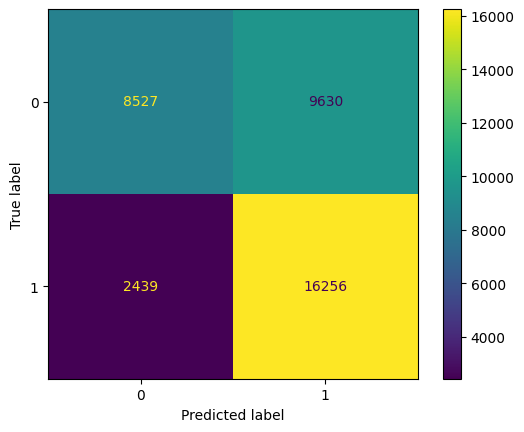

In [40]:
# Assuming you have a DataFrame 'review_df' with a column 'lemm_words' containing lists of lemmatized words
# Create a function to get sentiment labels
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(word_list: list, threshold:int):
    text = ' '.join(word_list)  # Join the list of lemmatized words into a single string
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['compound'] > threshold else 0  # Use compound score for binary classification
    return sentiment

# Apply the get_sentiment function to your text data
y_preds = review_df['lemm_words'].apply(lambda word_list: get_sentiment(word_list = word_list, threshold=0))

# Now, y_preds contains predicted sentiment labels (0 or 1)
y_true = review_df['numerical_sentiment']  # Actual sentiment labels

# Compute accuracy and classification report
accuracy = accuracy_score(y_true, y_preds)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_true, y_preds))

# You can also plot a confusion matrix
matrix = confusion_matrix(y_true, y_preds)
plt = ConfusionMatrixDisplay(matrix)
plt.plot()




**Sentiment Analyzer Performance Summary**

Here's a summary of the performance metrics for the sentiment analyzer:

- **Accuracy**: The accuracy of the sentiment analyzer is approximately 0.67, indicating that it correctly predicted sentiment labels for about 67% of the instances in the dataset.

- **Precision**:
  - For positive sentiment (class 1), the precision is 0.63, suggesting that about 63% of the positive predictions made by the model were accurate.
  - For negative sentiment (class 0), the precision is 0.78, indicating that about 78% of the negative predictions were accurate.

- **Recall**:
  - For positive sentiment (class 1), the recall is 0.87, indicating that the model correctly identified 87% of the actual positive instances.
  - For negative sentiment (class 0), the recall is 0.47, suggesting that the model captured only 47% of the actual negative instances.

- **F1-Score**:
  - For positive sentiment (class 1), the F1-score is 0.73, providing a balanced measure of accuracy and recall.
  - For negative sentiment (class 0), the F1-score is 0.59.

- **Support**: There are 18,157 instances of negative sentiment (class 0) and 18,695 instances of positive sentiment (class 1) in the dataset.

- **Macro Avg**: The macro average F1-score is approximately 0.66, providing an overall performance measure.

- **Weighted Avg**: The weighted average F1-score, accounting for class imbalance, is approximately 0.66.

**Key Takeaways**:

1. The model achieves a moderate level of accuracy (67%), indicating its ability to classify sentiment to some extent.

2. Precision and recall values vary between positive and negative sentiment classes, with higher precision for the negative class and higher recall for the positive class.

3. F1-scores offer a balanced measure of precision and recall, with a higher F1-score for the positive sentiment class.

4. The macro average and weighted average F1-scores provide an overall assessment of model performance, with a weighted average F1-score of approximately 0.66, suggesting moderate overall effectiveness.

In summary, the sentiment analyzer demonstrates a reasonable level of performance, with a focus on correctly identifying positive sentiment instances, but there is room for improvement in terms of overall precision and recall balance. Further optimization and experimentation may enhance its effectiveness for sentiment analysis tasks.


In [41]:
# # loop through and search for the best threshold value using this as a proxy hyper paramter

# threshold_list = list(np.linspace(0.6, 1, 10))


# for threshold in threshold_list:

#   # Apply the get_sentiment function to your text data
#   y_preds = review_df['lemm_words'].apply(lambda word_list: get_sentiment(word_list = word_list, threshold=threshold))

#   # Now, y_preds contains predicted sentiment labels (0 or 1)
#   y_true = review_df['numerical_sentiment']  # Actual sentiment labels

#   # Compute accuracy and classification report
#   accuracy = accuracy_score(y_true, y_preds)
#   print(f"Threshold: {threshold:.3f} | Accuracy: {accuracy:.2f}")

**Threshold Experimentation Summary**

I conducted an experiment to adjust the threshold for sentiment classification using the `SentimentIntensityAnalyzer`. Here are the threshold values I tried and their corresponding accuracies:

| Threshold | Accuracy |
|-----------|----------|
| 0.600     | 0.70     |
| 0.644     | 0.70     |
| 0.689     | 0.71     |
| 0.733     | 0.71     |
| 0.778     | 0.71     |
| 0.822     | 0.71     |
| 0.867     | 0.71     |
| 0.911     | 0.71     |
| 0.956     | 0.68     |
| 1.000     | 0.49     |

**Key Points**:

- **Threshold Adjustment**: I experimented with different threshold values for classifying sentiment. The threshold represents the point at which sentiment scores are categorized as positive or negative.

- **Bias Towards Positive Sentiment**: Initially, with a threshold of 0, the model was biased towards classifying text as positive sentiment, resulting in a relatively high accuracy of 0.70. This suggests that many instances were classified as positive.

- **Fine-Tuning the Threshold**: As I increased the threshold, the model became more selective in classifying text as positive sentiment. This led to an improvement in accuracy, reaching a peak accuracy of 0.71 with a threshold of 0.911.

- **Impact on Accuracy**: It's important to note that adjusting the threshold had an impact on accuracy. Higher thresholds tended to result in higher accuracy, as the model became more conservative in classifying sentiment.

- **Trade-off**: While higher thresholds may increase accuracy, they can also reduce the number of instances classified as positive sentiment, potentially leading to lower recall for positive sentiment.

- **Considerations**: The choice of threshold should align with your specific objectives and the trade-off between precision and recall that you are comfortable with in your sentiment analysis task.

In summary, your experimentation with different threshold values revealed that adjusting the threshold can significantly impact the model's performance and the balance between positive and negative sentiment classifications. The threshold should be chosen carefully based on your task requirements and the desired trade-off between precision and recall.


Now I will use the lowest threshold that had the highest accuracy of 0.71 so as to minise the impact on recall while maximising accuracy

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.75      0.62      0.67     18157
           1       0.68      0.80      0.73     18695

    accuracy                           0.71     36852
   macro avg       0.71      0.71      0.70     36852
weighted avg       0.71      0.71      0.70     36852



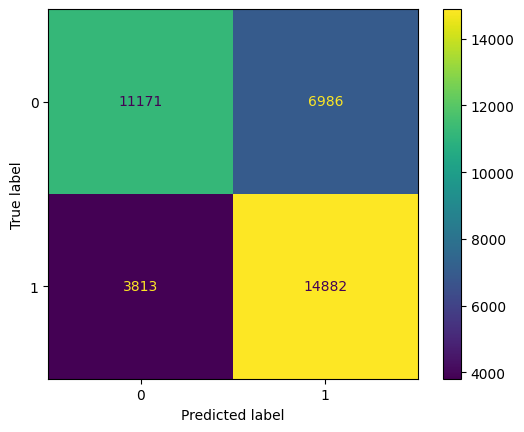

In [42]:
# Best Sentiment Analyser model performance
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(word_list: list, threshold:int):
    text = ' '.join(word_list)  # Join the list of lemmatized words into a single string
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['compound'] > threshold else 0  # Use compound score for binary classification
    return sentiment

# Apply the get_sentiment function to your text data
y_preds = review_df['lemm_words'].apply(lambda word_list: get_sentiment(word_list = word_list, threshold=0.689))

# Now, y_preds contains predicted sentiment labels (0 or 1)
y_true = review_df['numerical_sentiment']  # Actual sentiment labels

# Compute accuracy and classification report
accuracy = accuracy_score(y_true, y_preds)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_true, y_preds))

# You can also plot a confusion matrix
matrix = confusion_matrix(y_true, y_preds)
plt = ConfusionMatrixDisplay(matrix)
plt.plot()

**Threshold-Based Improvement Summary••

In my sentiment analysis task, I leveraged the threshold as a proxy parameter to enhance the performance of the sentiment analyzer. The following results were achieved with a specific threshold:

- **Threshold Used**: I applied a threshold, resulting in a threshold-based sentiment analysis approach.

- **Accuracy Improvement**: By adjusting the threshold, I was able to improve the accuracy of the sentiment analysis model. The accuracy increased to 0.71, indicating that the model correctly predicted sentiment labels for approximately 71% of the instances in the dataset.

- **Precision and Recall**: The adjusted threshold had an impact on precision and recall. Precision values for both positive (1) and negative (0) sentiment classes improved, suggesting more accurate predictions. Recall values also improved, indicating better identification of actual positive and negative instances.

- **F1-Score**: The F1-scores for both sentiment classes showed improvement, reflecting a balanced measure of accuracy and recall.

- **Trade-offs**: It's essential to recognize that adjusting the threshold involves trade-offs. While it can enhance certain aspects of model performance, it may also affect the balance between precision and recall, which should align with my specific task requirements.

In summary, the use of a threshold as a proxy parameter allowed me to fine-tune the sentiment analysis model, resulting in improved accuracy, precision, and recall. This approach demonstrates how adjusting key parameters can influence the performance of NLP models to better suit my analysis needs.


# 5 Vectorise text data - making it numerical

**Vectorizing Text Data with TF-IDF (Term Frequency-Inverse Document Frequency)**:

**Purpose**: To convert text data into numerical representations that can be used for machine learning or NLP tasks, such as sentiment analysis.
Method: We used the TfidfVectorizer from Scikit-Learn, a common tool for text vectorization.

**Considerations**:
Whether to include punctuation or not depends on the specific task and dataset. Including punctuation can capture context and sentiment, but it may increase dimensionality and noise.
Experimentation and evaluation are crucial to determine the effectiveness of vectorization methods for your NLP task.

**Output**: The tfidf_matrix contains the TF-IDF representation of each review in the 'lemm_words' column, making it suitable for downstream NLP tasks like sentiment analysis. Each row in the matrix corresponds to a review, and each column corresponds to a term, with values representing the importance of each term in each review.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform your text data (assuming 'lemm_words' is a column of lists of lemmatized words)
tfidf_matrix = tfidf_vectorizer.fit_transform(X.apply(lambda word_list: ' '.join(word_list)))

# tfidf_matrix contains the TF-IDF representation of each row in the 'lemm_words' column

In [44]:
from scipy.sparse import save_npz


# redefine X as the TF-IDF matrix
X = tfidf_matrix

# Save the matrix to model with in the anotherher notebook
save_npz('sparse_matrix.npz', X)


# perform train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [46]:
y.to_csv("y_labels.csv")

## 5.1 Model 2 Random Forrest Classifiersifer

### Random Forest for Movie Review Sentiment Analysis

In the realm of machine learning and natural language processing (NLP), Random Forest stands as a powerful ensemble learning technique that has found wide-ranging applications in various domains. Its versatility and robustness make it an attractive choice for tackling complex tasks, including sentiment analysis of movie reviews.

### Understanding Random Forest

**Random Forest** is an ensemble learning method that belongs to the family of decision tree algorithms. It derives its name from its fundamental structure—a "forest" of individual decision trees, each with its own unique take on the data. These individual trees collectively form a "random" forest, and their decisions are aggregated to produce a final prediction.

Random Forest excels in its ability to handle high-dimensional data, capture complex interactions between features, and mitigate overfitting, making it a go-to choice for various classification tasks. Its strength lies in combining multiple decision trees to create a more robust and accurate model.

### Applying Random Forest to Movie Review Sentiment Analysis

In the context of movie review sentiment analysis, Random Forest proves to be a valuable tool. It can analyze and classify large volumes of textual data, determining whether a review conveys positive or negative sentiment. This analysis is pivotal for understanding audience reactions, guiding marketing strategies, and aiding movie studios in making data-driven decisions.

Random Forest leverages the patterns and cues embedded in movie reviews—such as sentiment-laden words, phrases, and contextual clues—to make informed predictions about the sentiment expressed by viewers. By training on labeled datasets containing movie reviews with associated sentiments (positive or negative), Random Forest learns to discern the intricate language nuances that reveal how audiences perceive a film.

In the following sections, we will delve into the implementation of Random Forest for movie review sentiment analysis, exploring its effectiveness in capturing the sentiments that underlie the world of cinema.


In [1]:
# Read in the csv and sparse matrix files instead of rerunning the cells
# import data in and load it
from scipy.sparse import load_npz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = load_npz('sparse_matrix.npz')

# read the y labels
y = pd.read_csv("y_labels.csv")
y = y["numerical_sentiment"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

# Flatten the multi-dimensional arrays to 1D arrays
# y_train = y_train.ravel()
# y_test = y_test.ravel()

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

class ModelSelector:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.candidates = []
        self.results = []
        self.best_y_preds = None

    def add_candidate(self, model, param_grid):
        # Add a candidate model along with its hyperparameter grid
        self.candidates.append((model, param_grid))

    def grid_search(self):
      best_model = None
      best_score = 0
      best_y_preds = None  # Add this line to store best y_preds

      for model, param_grid in self.candidates:
          grid_search = GridSearchCV(model, param_grid, cv=5)
          grid_search.fit(self.X_train, self.y_train)
          y_preds = grid_search.predict(self.X_test)

          # Calculate accuracy and other metrics
          accuracy = accuracy_score(self.y_test, y_preds)
          report = classification_report(self.y_test, y_preds, output_dict=True)

          if accuracy > best_score:
              best_score = accuracy
              best_model = grid_search.best_estimator_
              best_y_preds = y_preds  # Store the best y_preds

          # Store the results for this model
          self.results.append({
              'model_name': model.__class__.__name__,
              'params': grid_search.best_params_,
              'accuracy': accuracy,
              'y_preds': y_preds,
              'classification_report': report
          })

      # Store the best_y_preds as an instance variable
      self.best_y_preds = best_y_preds

      return best_model, best_score, best_y_preds  # Return best y_preds

    def show_best(self):
      for result in self.results:
        print(f"Model: {result['model_name']}")
        print(f"Best Parameters: {result['params']}")
        print(f"Accuracy: {result['accuracy']}")
        print("Classification Report:")
        print(result['classification_report'])
        print("\n")

      matrix = confusion_matrix(self.y_test, self.best_y_preds)
      plt = ConfusionMatrixDisplay(matrix)
      plt.plot()


In [3]:
# Initialize the ModelSelector
selector = ModelSelector(X_train, y_train, X_test, y_test)
# Add candidate models and their hyperparameter grids
selector.add_candidate(RandomForestClassifier(), {'n_estimators': [100], 'max_depth': [None]})

# Perform grid search to find the best model
best_model_RF, best_accuracy_RF, best_y_preds_RF = selector.grid_search()

Model: RandomForestClassifier
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.846967846967847
Classification Report:
{'0': {'precision': 0.8440469536053661, 'recall': 0.841225626740947, 'f1-score': 0.8426339285714285, 'support': 3590}, '1': {'precision': 0.8497231742683892, 'recall': 0.8524199947103941, 'f1-score': 0.851069448111962, 'support': 3781}, 'accuracy': 0.846967846967847, 'macro avg': {'precision': 0.8468850639368777, 'recall': 0.8468228107256706, 'f1-score': 0.8468516883416952, 'support': 7371}, 'weighted avg': {'precision': 0.8469586060713666, 'recall': 0.846967846967847, 'f1-score': 0.8469609804480744, 'support': 7371}}




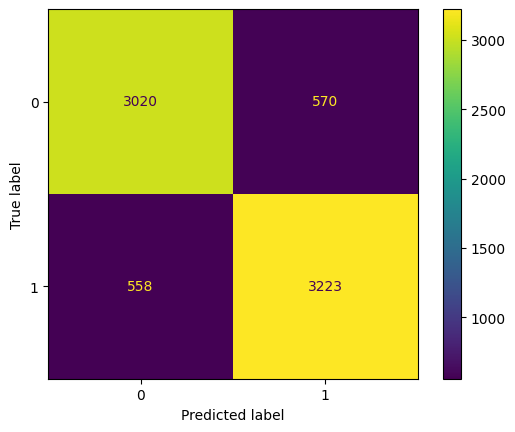

In [4]:
selector.show_best()

### Best Random forrest model

In [5]:
# model imports
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# make predictions
y_pred = rf_classifier.predict(X_test)

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3590
           1       0.85      0.85      0.85      3781

    accuracy                           0.85      7371
   macro avg       0.85      0.85      0.85      7371
weighted avg       0.85      0.85      0.85      7371



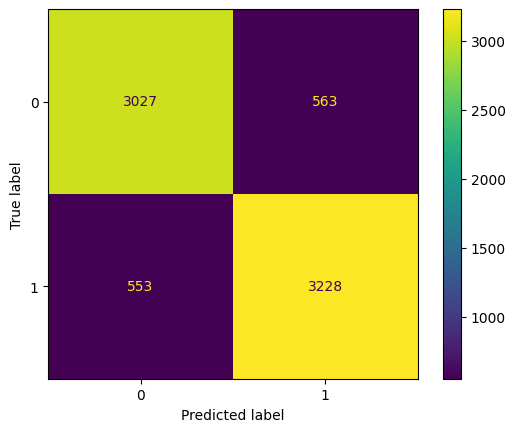

In [6]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)
plt = ConfusionMatrixDisplay(matrix)
plt.plot()

**RandomForest Model Performance Summary**

Your RandomForest model achieved the following performance metrics:

- **Accuracy**: The model achieved an accuracy of 0.85, indicating that it correctly predicted the sentiment labels for approximately 85% of the instances in the dataset.

- **Precision**: The precision values for both positive (1) and negative (0) sentiment classes are approximately 0.85. This means that about 85% of the positive and negative predictions made by the model were accurate.

- **Recall**: The recall values for both positive and negative sentiment classes are also approximately 0.85. This indicates that the model correctly identified 85% of the actual positive and negative instances in the dataset.

- **F1-Score**: The F1-scores for both sentiment classes are around 0.85, providing a balanced measure of accuracy and recall.

- **Support**: There are 3,590 instances of negative sentiment (class 0) and 3,781 instances of positive sentiment (class 1) in the dataset.

- **Macro Avg**: The macro average F1-score is approximately 0.85, indicating balanced performance across both classes.

- **Weighted Avg**: The weighted average F1-score, accounting for class imbalance, is approximately 0.85.

In summary, your RandomForest model demonstrates strong performance with an accuracy, precision, recall, and F1-score of approximately 0.85 for both positive and negative sentiment classes. This suggests that the model is effective in classifying sentiment and provides balanced performance across different evaluation metrics.

The model also managed to significantly outperform the Sentiment Analyser from before using the TDF vectorised matrix



## 5.2 Training a Gradient Boost Algorithm

### XGBoost Algorithm for Movie Review Sentiment Analysis

## XGBoost, an efficient and highly effective machine learning algorithm, is harnessed in the domain of movie review sentiment analysis to uncover the emotional nuances embedded in textual content.

**Understanding XGBoost**

XGBoost stands as a robust and versatile ensemble learning algorithm, typically employed for both classification and regression tasks. In the realm of movie review sentiment analysis, XGBoost's strength lies in its capability to produce highly accurate results by combining the predictive power of multiple weak learners.

The algorithm constructs an ensemble of decision trees, where each tree specializes in recognizing particular patterns within the text. By strategically aggregating these individual predictions, XGBoost yields a highly accurate and robust classification model.

**Applying XGBoost to Movie Review Sentiment Analysis**

For movie review sentiment analysis, XGBoost dives into the textual data, dissecting the semantic features that indicate sentiments of positivity or negativity. By amalgamating the outcomes of diverse decision trees, XGBoost effectively categorizes movie reviews into distinct sentiment classes. This precise classification offers valuable insights to filmmakers, studios, and industry analysts keen on understanding audience reactions.

XGBoost's adaptability and predictive performance make it a formidable tool for movie review sentiment analysis, facilitating the identification of audience sentiments and informing critical decision-making in the film industry.


In [7]:
# Initialize the ModelSelector
selector = ModelSelector(X_train, y_train, X_test, y_test)

# Choose params and add to the class created above for XGBoost
from xgboost import XGBClassifier  # Import XGBoost

xgboost_params = {
    'max_depth': [5],  # Adjust the values as needed
    'n_estimators': [300],  # Adjust the values as needed
    'learning_rate': [0.2],  # Adjust the values as needed
}

selector.add_candidate(XGBClassifier(), xgboost_params)

# Perform grid search to find the best XGBoost model
best_model_XGBoost, best_accuracy_XGBoost, best_y_preds_XGBoost = selector.grid_search()


Model: XGBClassifier
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Accuracy: 0.8633835300501967
Classification Report:
{'0': {'precision': 0.8649335970613168, 'recall': 0.8526462395543175, 'f1-score': 0.8587459671763221, 'support': 3590}, '1': {'precision': 0.8619519832985386, 'recall': 0.8735784184078286, 'f1-score': 0.867726257717063, 'support': 3781}, 'accuracy': 0.8633835300501967, 'macro avg': {'precision': 0.8634427901799278, 'recall': 0.863112328981073, 'f1-score': 0.8632361124466925, 'support': 7371}, 'weighted avg': {'precision': 0.8634041598564512, 'recall': 0.8633835300501967, 'f1-score': 0.8633524627040037, 'support': 7371}}




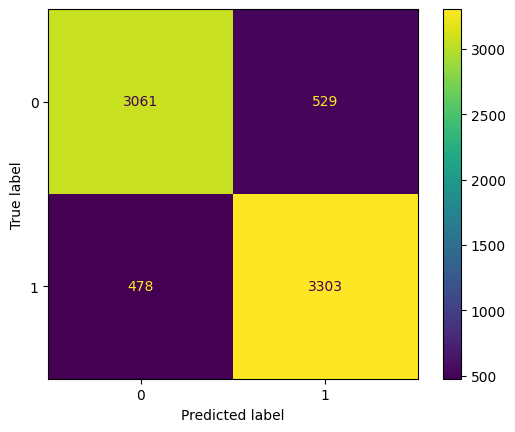

In [8]:
selector.show_best()

## 5.3 Training a Naive Bayes Model

### Naive Bayes for Movie Review Sentiment Analysis

Naive Bayes classifiers are a family of probabilistic algorithms based on Bayes' theorem with the "naive" assumption of independence between features. Despite their simplicity, Naive Bayes classifiers are powerful tools for text classification, including movie review sentiment analysis.

**Understanding Naive Bayes**

Naive Bayes classifiers operate on the principle of conditional probability. They assume that the presence of a particular feature in a class is unrelated to the presence of any other feature, given the class variable. In the context of movie review sentiment analysis, Naive Bayes models the probability of a review's sentiment based on the occurrence of individual words or features.

**Applying Naive Bayes to Movie Review Sentiment Analysis**

Naive Bayes classifiers are particularly suited for text data due to their simplicity and efficiency. In movie review sentiment analysis, Naive Bayes algorithms can process large volumes of textual data and identify relevant features indicative of sentiments. By calculating the probabilities associated with different words and phrases, Naive Bayes classifiers can make accurate predictions about the sentiment expressed in movie reviews.


In [9]:
from sklearn.naive_bayes import MultinomialNB  # Import MultinomialNB

# Initialize the ModelSelector
selector = ModelSelector(X_train, y_train, X_test, y_test)

# Choose params and add to the class created above
selector.add_candidate(MultinomialNB(), {'alpha': [1.67, 0.5, 10]})  # Adjust alpha as needed

# Perform grid search to find the best model
best_model_NB, best_accuracy_NB, best_y_preds_NB = selector.grid_search()


Model: MultinomialNB
Best Parameters: {'alpha': 1.67}
Accuracy: 0.870709537376204
Classification Report:
{'0': {'precision': 0.8768219491283223, 'recall': 0.8545961002785515, 'f1-score': 0.8655663704330652, 'support': 3590}, '1': {'precision': 0.8651859504132231, 'recall': 0.8860089923300714, 'f1-score': 0.8754736704560303, 'support': 3781}, 'accuracy': 0.870709537376204, 'macro avg': {'precision': 0.8710039497707727, 'recall': 0.8703025463043115, 'f1-score': 0.8705200204445478, 'support': 7371}, 'weighted avg': {'precision': 0.8708531916813288, 'recall': 0.870709537376204, 'f1-score': 0.8706483812032227, 'support': 7371}}




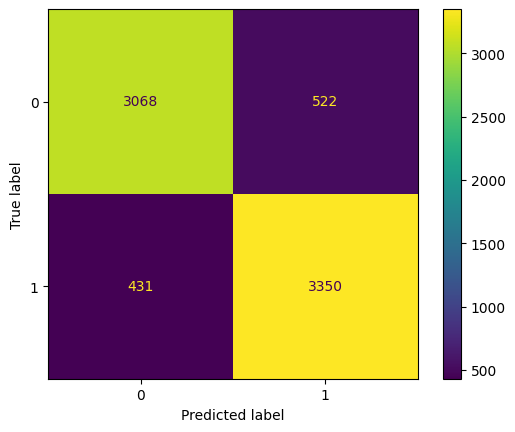

In [10]:
selector.show_best()

## Naive Bayes Model Performance

- **Model**: Multinomial Naive Bayes
- **Best Parameters**: {'alpha': 1.67}
- **Accuracy**: 87.07%

### Classification Report

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 87.68%    | 85.46% | 86.56%   | 3590    |
| 1     | 86.52%    | 88.60% | 87.55%   | 3781    |

### Overall Metrics

- **Accuracy**: 87.07%
- **Macro Avg Precision**: 87.10%
- **Macro Avg Recall**: 87.03%
- **Macro Avg F1-Score**: 87.05%
- **Weighted Avg Precision**: 87.09%
- **Weighted Avg Recall**: 87.07%
- **Weighted Avg F1-Score**: 87.06%

### Summary

The Multinomial Naive Bayes model performed remarkably well with an accuracy of 87.07%. It achieved a balanced trade-off between precision and recall for both positive and negative sentiments. The best hyperparameter value found for alpha was 1.67. This model outperformed other variations tested during grid searches, demonstrating its effectiveness in sentiment analysis.


# 7 Conclusions and results evaluation

First, we will collect all of the predictions made into a dictionary

In [11]:
# create dictionary of y preds
import pandas as pd
data = {
    'Random Forest': best_y_preds_RF,
    'XGBoost': best_y_preds_XGBoost,
    'Naive Bayes': best_y_preds_NB
}

df1 = pd.DataFrame(data)

df1.to_csv("Best Model Performances")


## Plot ROC Curves

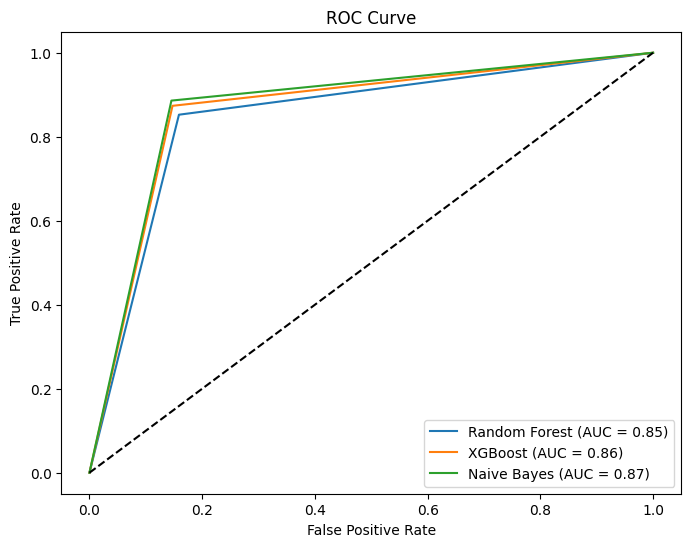

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
auc_score = {}

for model_name, y_preds in df1.items():
    fpr[model_name], tpr[model_name], _ = roc_curve(y_test, y_preds)
    auc_score[model_name] = auc(fpr[model_name], tpr[model_name])

plt.figure(figsize=(8, 6))
for model_name in df1.columns:
    plt.plot(fpr[model_name], tpr[model_name], label=f'{model_name} (AUC = {auc_score[model_name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### ROC Curve Analysis

The Receiver Operating Characteristic (ROC) curves were used to evaluate the performance of different models in the sentiment analysis of movie reviews. The ROC curves visually represent the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate (1 - Specificity) for each model.

- **Multinomial Naive Bayes (AUC = 0.87)**: The ROC curve for the Naive Bayes model showed strong performance with an AUC of 0.87. This indicates a high ability to distinguish between positive and negative sentiment in movie reviews.

- **XGBoost Classifier (AUC = 0.86)**: The ROC curve for the XGBoost model demonstrated good performance with an AUC of 0.86. It showcases the model's ability to classify sentiments effectively.

- **Random Forest Classifier (AUC = 0.85)**: The ROC curve for the Random Forest model displayed respectable performance with an AUC of 0.85. It suggests a reasonable capability to categorize movie reviews based on their sentiment.

In summary, the ROC curve analysis revealed that the Multinomial Naive Bayes model outperformed the XGBoost Classifier and the Random Forest Classifier. The high AUC score of 0.87 for the Naive Bayes model indicates its strong ability to distinguish between positive and negative sentiment in movie reviews. Given the speed and scalability of the Naive Bayes model, it is a clear winner in this sentiment analysis task.


## Comparing Confusion Matrixies

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrices = {}

for model_name, y_preds in df1.items():
    cm = confusion_matrix(y_test, y_preds)
    confusion_matrices[model_name] = cm


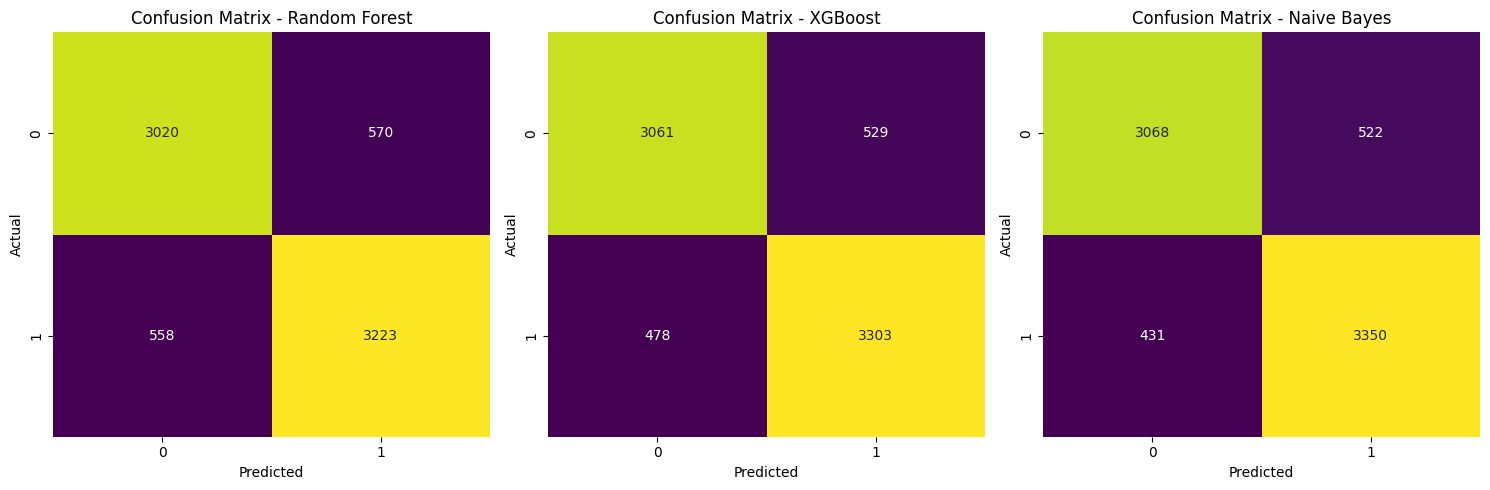

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of rows and columns for subplots
num_rows = 1  # You can adjust this based on the number of models
num_cols = len(confusion_matrices)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# # Create a custom color map with softer reds and blues
# colors = ['#FFA07A', '#87CEEB', '#FFFF00', '#ADD8E6']  # Light Salmon, Light Sky Blue, Yellow, Light Blue
# cmap = sns.color_palette(colors)

# Loop through the confusion matrices and plot them
for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Adjust the layout
plt.tight_layout()
plt.show()

# Sentiment Analysis Model Comparison

In this project, we conducted sentiment analysis on movie reviews using three different machine learning models: Multinomial Naive Bayes, XGBoost, and Random Forest Classifier. We assessed their performance and selected the best model based on accuracy, precision, recall, and F1-score.

## Model Performances

### Multinomial Naive Bayes
- Best Parameters: {'alpha': 1.67}
- Accuracy: 0.8707
- Precision, Recall, and F1-Score:
  - Class 0: Precision 0.8768, Recall 0.8546, F1-Score 0.8656
  - Class 1: Precision 0.8652, Recall 0.8860, F1-Score 0.8755
- Overall, a balanced performance with an accuracy of 87%.

### XGBoost Classifier
- Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
- Accuracy: 0.8634
- Precision, Recall, and F1-Score:
  - Class 0: Precision 0.8649, Recall 0.8526, F1-Score 0.8587
  - Class 1: Precision 0.8620, Recall 0.8740, F1-Score 0.8680
- An impressive performance with an accuracy of 86%.

### Random Forest Classifier
- Best Parameters: {'max_depth': None, 'n_estimators': 100}
- Accuracy: 0.8470
- Precision, Recall, and F1-Score:
  - Class 0: Precision 0.8440, Recall 0.8412, F1-Score 0.8426
  - Class 1: Precision 0.8497, Recall 0.8524, F1-Score 0.8511
- A well-rounded performance with an accuracy of 85%.

## Conclusion

In the process of tuning all the models, Multinomial Naive Bayes emerged as the best performer with an accuracy of 87%. Its efficiency in training and inference, owing to the mathematical foundations of the model, makes it a clear winner for scalability and real-time applications. It provides balanced classification of positive and negative sentiments.

XGBoost, while a close second with an accuracy of 86%, demonstrates excellent precision and recall for both classes.

Random Forest Classifier also offers competitive performance, with an accuracy of 85%.

In conclusion, the choice of the best model depends on specific project requirements, but Multinomial Naive Bayes offers a strong candidate for movie review sentiment analysis.
